In [1]:
# 1. Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct
from sklearn.model_selection import GridSearchCV, KFold

In [2]:
#2. Read data
import yfinance as yf

data = yf.download(tickers = "GLD", start="2017-12-01", end="2023-06-16", interval='1d')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-01,120.940002,122.430000,120.739998,121.589996,121.589996,13080100
2017-12-04,121.150002,121.199997,120.839996,121.180000,121.180000,6943700
2017-12-05,120.099998,120.510002,119.720001,120.320000,120.320000,10041200
2017-12-06,120.040001,120.440002,119.870003,120.070000,120.070000,6643000
2017-12-07,119.010002,119.239998,118.099998,118.489998,118.489998,12900200
...,...,...,...,...,...,...
2023-06-09,182.360001,182.789993,181.720001,182.039993,182.039993,4379200
2023-06-12,181.800003,181.940002,181.039993,181.880005,181.880005,4873600
2023-06-13,182.100006,182.429993,180.169998,180.539993,180.539993,5126700


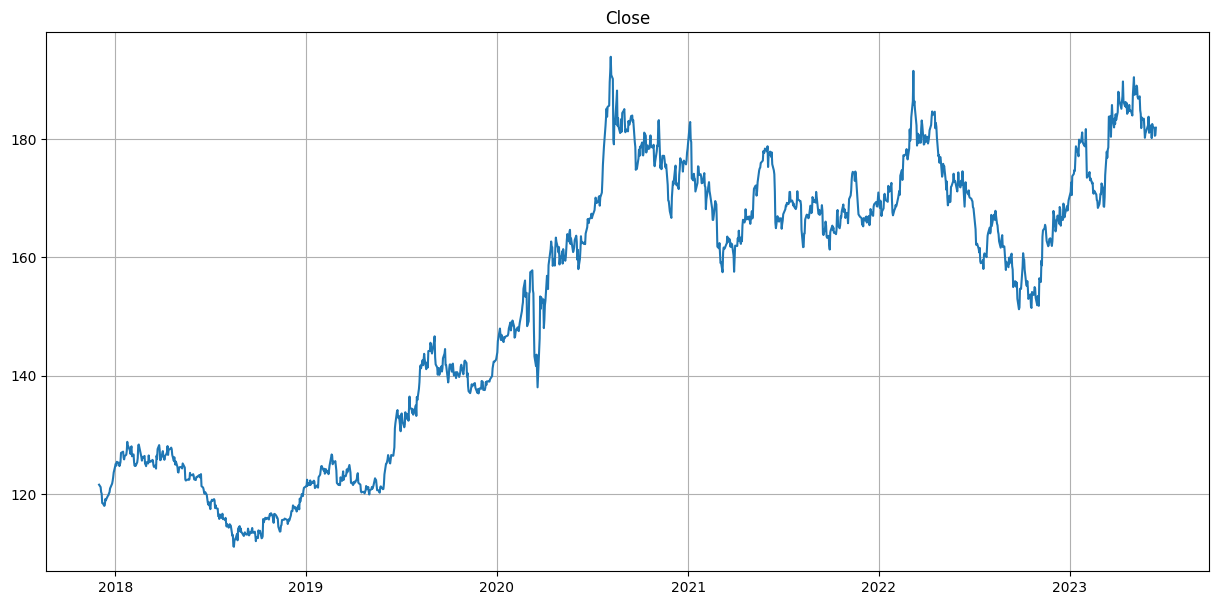

In [3]:
plt.figure(figsize=(15, 7))
plt.plot(data['Close'])
plt.title('Close')
plt.grid(True)
plt.show()

In [4]:
data = data.reset_index('Date', inplace=False)

In [5]:
# 4. Split train test
data = data[['Close']]
data = data.dropna() # Drop missing values
data = data.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [6]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

In [7]:
pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 102.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 15.2 MB/s eta 0:00:00


In [8]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

In [9]:
simple_exp = ExponentialSmoothing(trend=None, seasonal=None)

In [10]:
#5. Fit model with train data
simple_exp.fit(y_train)

ExponentialSmoothing()

In [11]:
# 6. Testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
#y_pred = model.predict(n_periods=len(y_test))

# 7. Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
#y_pred_val =  model.predict(n_periods=len(y_val))

In [12]:
y_pred = simple_exp.predict(test_data.index)

In [13]:
y_pred_val= simple_exp.predict(val_data.index)

In [14]:
#8. Predict next 30 days
last_index =  data.index[-1]
fh = list(range(last_index,last_index+30))
y_next_30_days = simple_exp.predict(fh)

In [15]:
# 9. Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))

print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 8.83297593115742
Validation RMSE: 14.296259969659795
Testing MAE: 7.134100207877254
Validation MAE: 12.301355380626687
Testing MAPE: 0.04194922643725554
Validation MAPE: 0.067687887860218


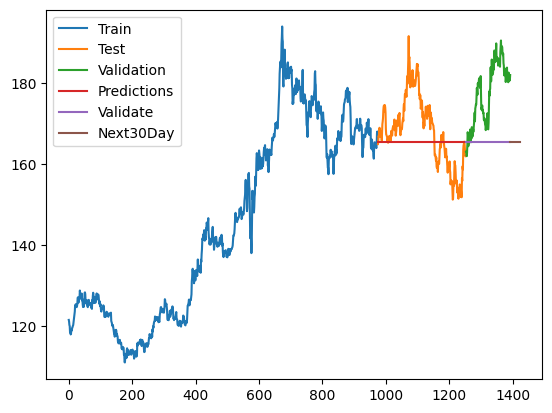

In [17]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(range(last_index+1, last_index+31),y_next_30_days)
plt.legend(['Train', 'Test', 'Validation', 'Predictions','Validate','Next30Day'])
plt.show()